# Imports

In [1]:
from typing import List
from itertools import product
import pandas as pd
import numpy as np
import holidays
import seaborn as sns
import warnings
warnings.simplefilter("ignore")
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.metrics import RocCurveDisplay, mean_absolute_error as mae

# Data loading and preprocessing for predicting events

## Train

In [2]:
events_train = pd.read_csv("../data/events_train.csv", parse_dates=True)
counters_train = pd.read_csv("../data/counters_train.csv", parse_dates=True)

events_train.dt_start = events_train.dt_start.apply(pd.to_datetime)
events_train.dt_end = events_train.dt_end.apply(pd.to_datetime)

In [3]:
counters_in = counters_train[counters_train.direction == 'in'][['dt', 'cnt']]
counters_out = counters_train[counters_train.direction == 'out'][['dt', 'cnt']]
counters_in['dt'] = counters_in.dt.apply(pd.to_datetime)
counters_out['dt'] = counters_out.dt.apply(pd.to_datetime)
counters_in = counters_in.set_index('dt')
counters_out = counters_out.set_index('dt')

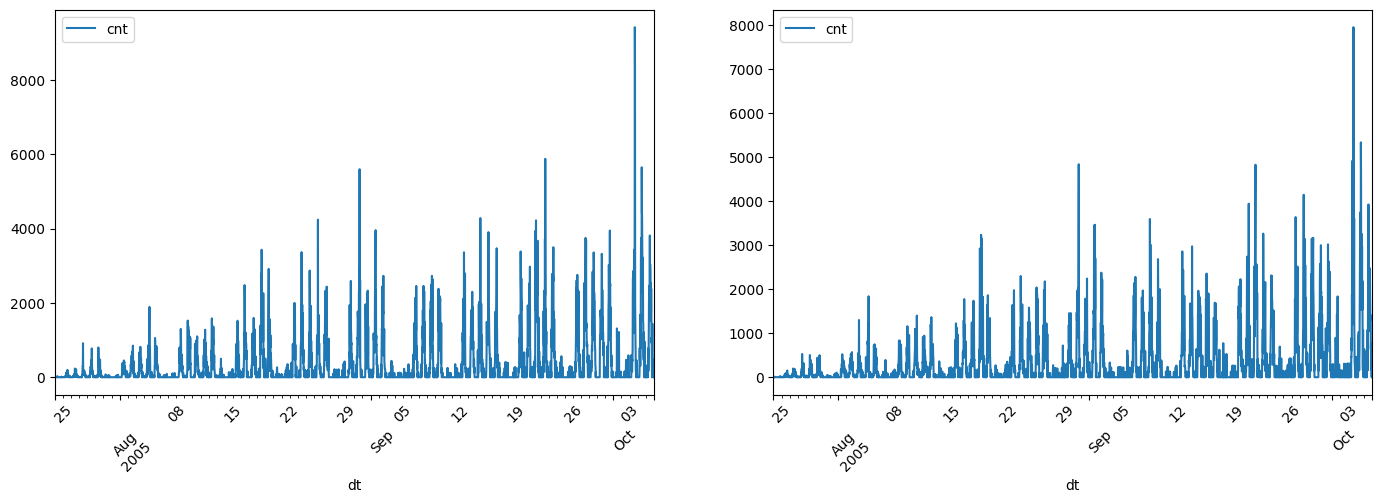

In [4]:
fig, ax = plt.subplots(1,2, figsize=(17, 5))
counters_in.plot(rot=45, ax=ax[0])
counters_out.plot(rot=45, ax=ax[1])
plt.show()

<AxesSubplot: xlabel='cnt', ylabel='Count'>

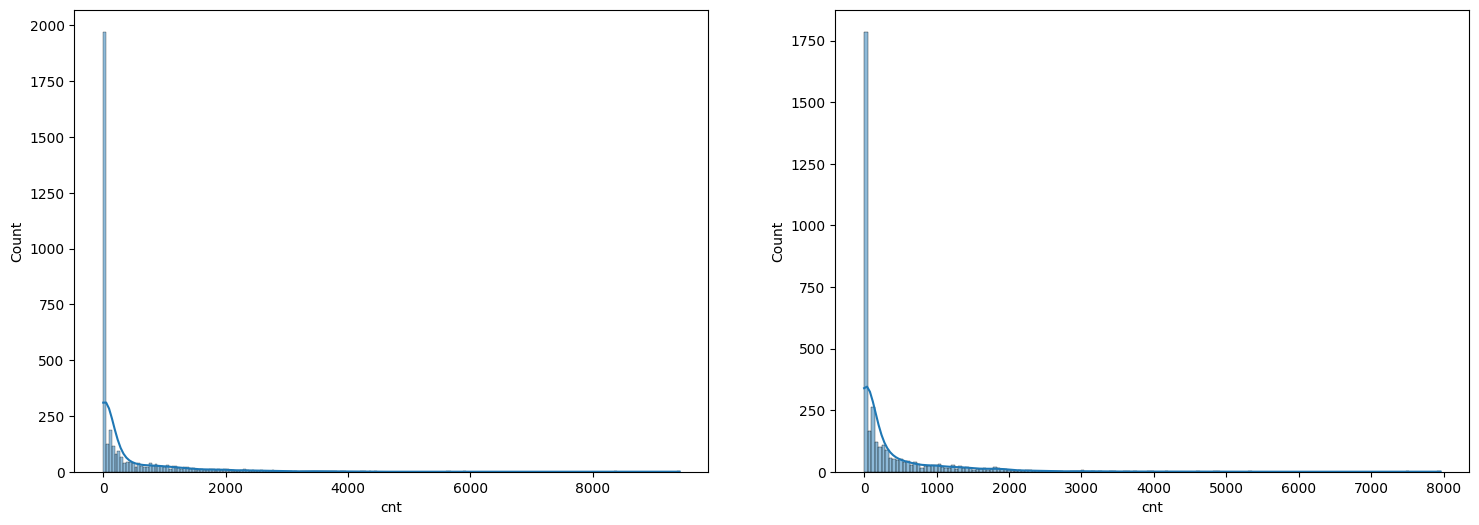

In [5]:
fig, ax = plt.subplots(1,2, figsize=(18, 6))
sns.histplot(counters_in.cnt, kde=True, ax=ax[0])
sns.histplot(counters_out.cnt, kde=True, ax=ax[1])

In [6]:
counters_in = counters_in.asfreq(freq='30min')
counters_out = counters_out.asfreq(freq='30min')

In [7]:
def accumulate_flow(feature:pd.Series) -> List[int]:
    accumulator = []
    cumulative_sum = 0
    
    for flow in feature:
        cumulative_sum += flow
        accumulator.append(cumulative_sum)
        
    return accumulator

In [8]:
counters_in['cumulative_flow'] = accumulate_flow(counters_in.cnt)
counters_out['cumulative_flow'] = accumulate_flow(counters_out.cnt)

In [9]:
counters_train = pd.DataFrame(columns=['dt', 'cnt'])

counters_train['dt'] = counters_in.index
counters_train['cnt'] = counters_in.cumulative_flow.values - counters_out.cumulative_flow.values

counters_train = counters_train.set_index('dt')
counters_train = counters_train.asfreq(freq='30min')

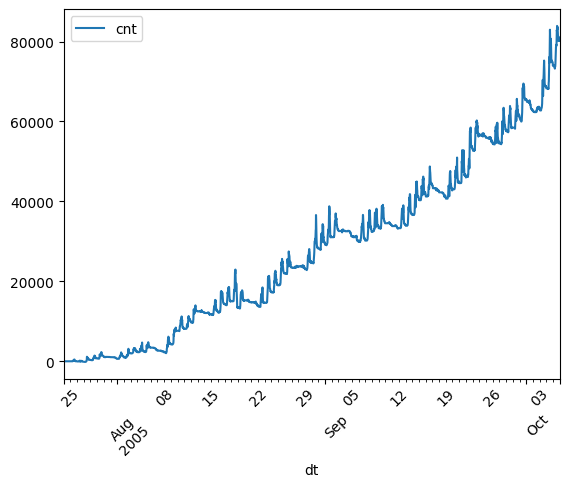

In [10]:
counters_train.plot(rot=45);

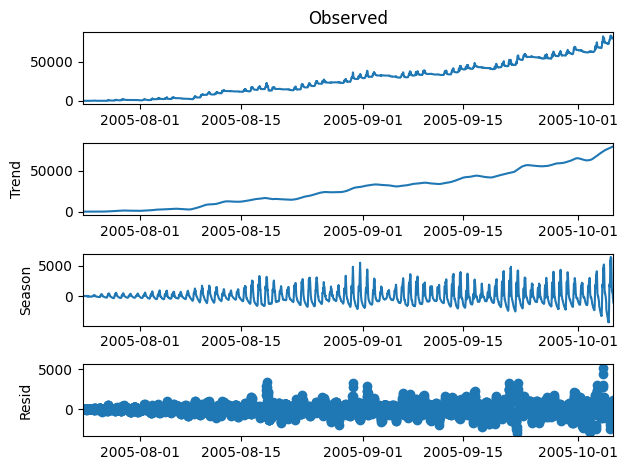

In [11]:
stl_res = STL(counters_train, period=24*2).fit()
stl_res.plot();

In [12]:
events_train.head(5)

,dt_start,dt_end,event_type
0,2005-07-26 11:00:00,2005-07-26 14:00:00,event
1,2005-07-29 08:00:00,2005-07-29 11:00:00,event
2,2005-08-02 15:30:00,2005-08-02 16:30:00,event
3,2005-08-04 16:30:00,2005-08-04 17:30:00,event
4,2005-08-05 08:00:00,2005-08-05 11:00:00,event


In [13]:
def check_if_event(timestamps, events) -> List[int]:
    labels = []
    event = False
    
    for timestamp in timestamps:
        event = False
        
        for i in range(len(events)):            
            if events.iloc[i]['dt_start'] <= timestamp <= events.iloc[i]['dt_end']:
                event = True
                
        if event:
            labels.append(1)
        else:
            labels.append(0)
        
    return labels

In [14]:
train_dataset = pd.DataFrame(columns=['dt', 'seasonal_feature_transformed', 'event'])
us_holidays = holidays.US()

train_dataset['dt'] = counters_train.index
train_dataset['seasonal_feature_transformed'] = np.log(stl_res.seasonal.values - np.min(stl_res.seasonal) + 1)
train_dataset['event'] = check_if_event(train_dataset.dt, events_train)
train_dataset['holiday'] = train_dataset.dt.apply(lambda x: 1 if x.date() in us_holidays else 0)
train_dataset['weekend'] = train_dataset.dt.apply(lambda x: 1 if x.date().weekday() in (5, 6) else 0)

train_dataset = train_dataset.set_index('dt')

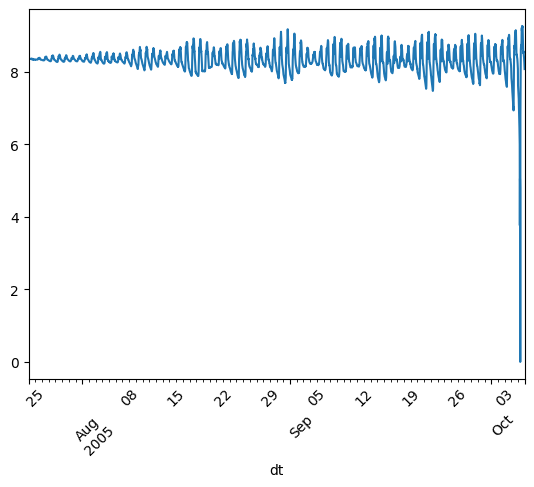

In [15]:
train_dataset.seasonal_feature_transformed.plot(rot=45);

In [16]:
train_dataset.head(5)

,seasonal_feature_transformed,event,holiday,weekend
dt,,,,
2005-07-24 00:00:00,8.358686,0,0,1
2005-07-24 00:30:00,8.356023,0,0,1
2005-07-24 01:00:00,8.356937,0,0,1
2005-07-24 01:30:00,8.357075,0,0,1
2005-07-24 02:00:00,8.357122,0,0,1


In [17]:
train_features = ["seasonal_feature_transformed", "holiday", "weekend"]
cat_features = ["holiday", "weekend"]
target = "event"

In [18]:
x_train, y_train = train_dataset[train_features], train_dataset[target].values.reshape(-1, 1)

In [19]:
x_train.shape, y_train.shape

((3552, 3), (3552, 1))

## Test

In [20]:
counters_test = pd.read_csv("../data/counters_test.csv", parse_dates=True)
events_test = pd.read_csv("../data/events_test.csv", parse_dates=True)

events_test['dt_start'] = events_test.dt_start.apply(pd.to_datetime)
events_test['dt_end'] = events_test.dt_end.apply(pd.to_datetime)

In [21]:
counters_test['dt'] = counters_test.dt.apply(pd.to_datetime)
counters_test_in = counters_test[counters_test.direction == 'in'][['dt', 'cnt']]
counters_test_out = counters_test[counters_test.direction == 'out'][['dt', 'cnt']]
counters_test_in = counters_test_in.set_index('dt')
counters_test_out = counters_test_out.set_index('dt')

In [22]:
counters_test_in['cumulative_flow'] = accumulate_flow(counters_test_in.cnt)
counters_test_out['cumulative_flow'] = accumulate_flow(counters_test_out.cnt)

In [23]:
counters_test = pd.DataFrame(columns=['dt', 'cnt'])

counters_test['dt'] = counters_test_in.index
counters_test['cnt'] = counters_test_in.cumulative_flow.values - counters_test_out.cumulative_flow.values

counters_test = counters_test.set_index('dt')
counters_test = counters_test.asfreq("30min")

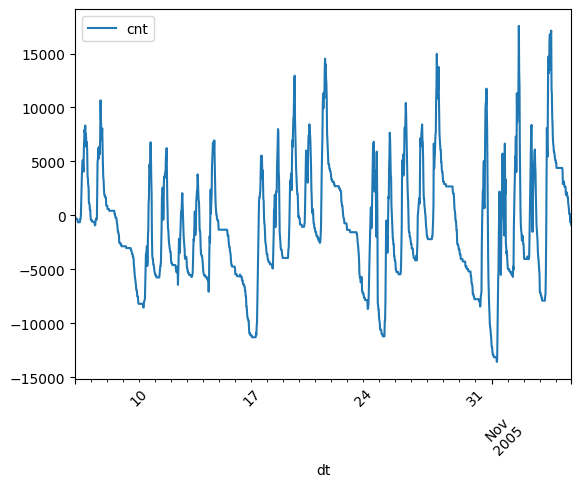

In [24]:
counters_test.plot(rot=45);

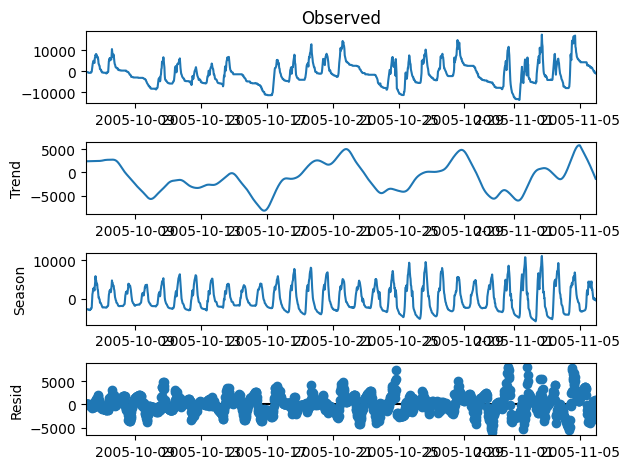

In [25]:
stl_res = STL(counters_test, period=24*2).fit()
stl_res.plot();

In [26]:
test_dataset = pd.DataFrame()

test_dataset['dt'] = counters_test.index
test_dataset['seasonal_feature_transformed'] = np.log(stl_res.seasonal.values - np.min(stl_res.seasonal) + 1)
test_dataset['event'] = check_if_event(test_dataset.dt, events_test)
test_dataset['holiday'] = test_dataset.dt.apply(lambda x: 1 if x.date() in us_holidays else 0)
test_dataset['weekend'] = test_dataset.dt.apply(lambda x: 1 if x.date().weekday() in (5, 6) else 0)

test_dataset = test_dataset.set_index("dt")

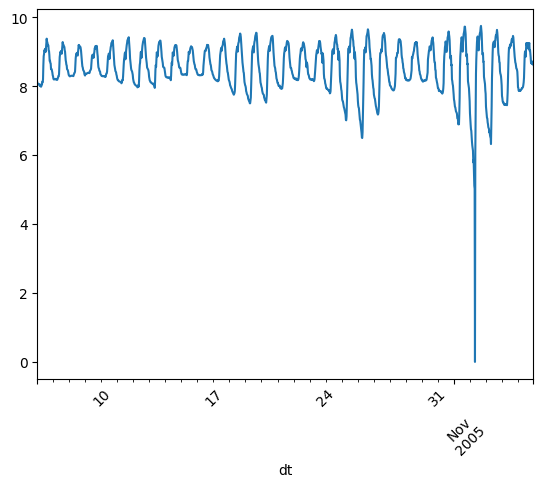

In [27]:
test_dataset.seasonal_feature_transformed.plot(rot=45);

In [28]:
test_dataset.head(5)

,seasonal_feature_transformed,event,holiday,weekend
dt,,,,
2005-10-06 00:00:00,8.102906,0,0,0
2005-10-06 00:30:00,8.062117,0,0,0
2005-10-06 01:00:00,8.065516,0,0,0
2005-10-06 01:30:00,8.049780,0,0,0
2005-10-06 02:00:00,8.056085,0,0,0


In [29]:
x_test, y_test = test_dataset[train_features], test_dataset[target].values.reshape(-1, 1)

# Building and fitting model for event prediction

In [30]:
catboost = CatBoostClassifier(depth=6)

catboost.fit(x_train, y_train, 
             silent=True,
             cat_features=cat_features,
             eval_set=(x_test, y_test))

# Event prediction model evaluation and metrics

In [31]:
preds = catboost.predict_proba(x_test)[:, 1]

In [32]:
x_test.shape, y_test.shape

((1488, 3), (1488, 1))

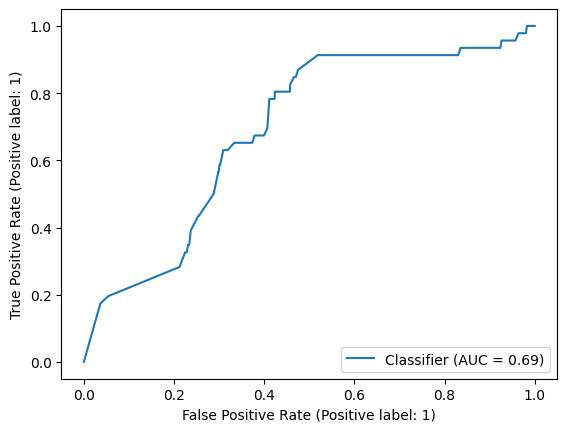

In [33]:
RocCurveDisplay.from_predictions(y_test, preds);

В данной задаче целесообразно максимизировать *ROC-AUC*, т.к в данных наблюдается сильный дисбаланс классов

# Data loading and preprocessing for timeseries prediction

## Train

In [34]:
train_data = counters_in.diff(48)[48:]

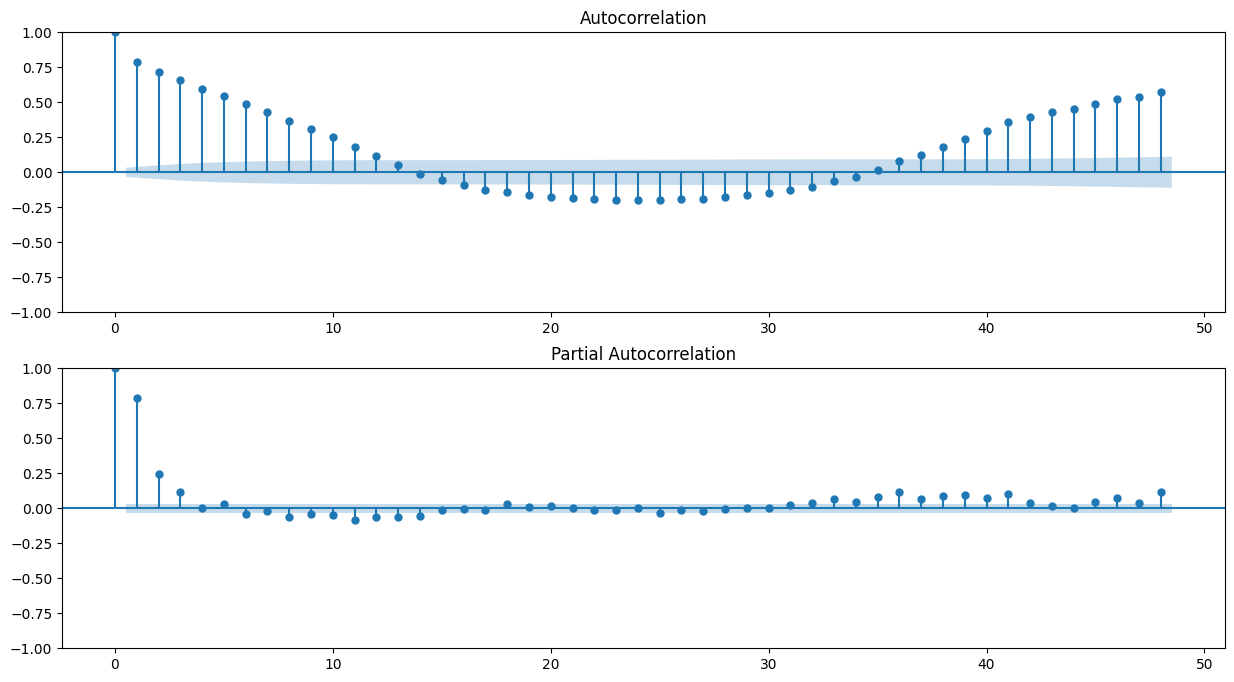

In [35]:
plt.figure(figsize=(15,8))

ax = plt.subplot(211)
plot_acf(counters_in.cnt, lags=48, ax=ax)

ax = plt.subplot(212)
plot_pacf(counters_in.cnt, lags=48, ax=ax)

plt.show()

In [41]:
%%time
results = []
best_aic = float("inf")

p = range(0,3)
q = range(1,3)
d = range(1,2)
s = range(48,49)

pdq = list(product(p, d, q))
seasonal_pdq = list(product(p, d, q, s))

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(counters_in.cnt,
                                    order=param,
                                    seasonal_order=param_seasonal).fit(max_iter = 50, method = 'powell')
            print('SARIMA{},{} - AIC:{}'.format(param, param_seasonal, mod.aic))

        except ValueError:
            print('wrong parameters:', param)
            continue
        aic = mod.aic

        if aic < best_aic:
            best_model = mod
            best_aic = aic
            best_param = (param, param_seasonal)
        results.append([param, mod.aic])
    

/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 7.993985
         Iterations: 3
         Function evaluations: 116
SARIMA(0, 1, 1),(0, 1, 1, 48) - AIC:23796.099708741942


/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 7.993857
         Iterations: 3
         Function evaluations: 147
SARIMA(0, 1, 1),(0, 1, 2, 48) - AIC:23797.717936004447


/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 7.993885
         Iterations: 3
         Function evaluations: 149
SARIMA(0, 1, 1),(1, 1, 1, 48) - AIC:23797.802143221328


/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 7.993922
         Iterations: 3
         Function evaluations: 187
SARIMA(0, 1, 1),(1, 1, 2, 48) - AIC:23799.912655296932


/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 7.996759
         Iterations: 4
         Function evaluations: 244
SARIMA(0, 1, 1),(2, 1, 1, 48) - AIC:23808.354349817037


/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 7.993992
         Iterations: 3
         Function evaluations: 220
SARIMA(0, 1, 1),(2, 1, 2, 48) - AIC:23802.120976111677


/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 7.991728
         Iterations: 3
         Function evaluations: 146
SARIMA(0, 1, 2),(0, 1, 1, 48) - AIC:23791.382064710568


/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 7.991638
         Iterations: 3
         Function evaluations: 178
SARIMA(0, 1, 2),(0, 1, 2, 48) - AIC:23793.11408068713


/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 7.991668
         Iterations: 3
         Function evaluations: 180
SARIMA(0, 1, 2),(1, 1, 1, 48) - AIC:23793.204006427404


/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 7.991681
         Iterations: 3
         Function evaluations: 218
SARIMA(0, 1, 2),(1, 1, 2, 48) - AIC:23795.24216404419


/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 7.994382
         Iterations: 4
         Function evaluations: 289
SARIMA(0, 1, 2),(2, 1, 1, 48) - AIC:23803.28062904336


/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 7.991776
         Iterations: 3
         Function evaluations: 251
SARIMA(0, 1, 2),(2, 1, 2, 48) - AIC:23797.524257704863


/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 7.992012
         Iterations: 3
         Function evaluations: 147
SARIMA(1, 1, 1),(0, 1, 1, 48) - AIC:23792.226602749586


/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 7.991866
         Iterations: 3
         Function evaluations: 177
SARIMA(1, 1, 1),(0, 1, 2, 48) - AIC:23793.793295764674


/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 7.991949
         Iterations: 3
         Function evaluations: 181
SARIMA(1, 1, 1),(1, 1, 1, 48) - AIC:23794.04051873908


/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 7.991905
         Iterations: 3
         Function evaluations: 220
SARIMA(1, 1, 1),(1, 1, 2, 48) - AIC:23795.90831120744


/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 7.994567
         Iterations: 4
         Function evaluations: 286
SARIMA(1, 1, 1),(2, 1, 1, 48) - AIC:23803.831939184274


/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 7.991975
         Iterations: 3
         Function evaluations: 251
SARIMA(1, 1, 1),(2, 1, 2, 48) - AIC:23798.116576485147


/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 7.992534
         Iterations: 3
         Function evaluations: 224
SARIMA(1, 1, 2),(0, 1, 1, 48) - AIC:23795.782587130114


/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 7.992356
         Iterations: 3
         Function evaluations: 267
SARIMA(1, 1, 2),(0, 1, 2, 48) - AIC:23797.252919257975


/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 7.992353
         Iterations: 4
         Function evaluations: 323
SARIMA(1, 1, 2),(1, 1, 1, 48) - AIC:23797.241078302846


/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 7.992446
         Iterations: 3
         Function evaluations: 309
SARIMA(1, 1, 2),(1, 1, 2, 48) - AIC:23799.5184299729


/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 7.995357
         Iterations: 4
         Function evaluations: 392
SARIMA(1, 1, 2),(2, 1, 1, 48) - AIC:23808.183223391083


/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 7.992514
         Iterations: 3
         Function evaluations: 338
SARIMA(1, 1, 2),(2, 1, 2, 48) - AIC:23801.7218970314


/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 7.992659
         Iterations: 3
         Function evaluations: 178
SARIMA(2, 1, 1),(0, 1, 1, 48) - AIC:23796.152671159965


/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 7.992502
         Iterations: 3
         Function evaluations: 214
SARIMA(2, 1, 1),(0, 1, 2, 48) - AIC:23797.68728081282


/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 7.992524
         Iterations: 3
         Function evaluations: 212
SARIMA(2, 1, 1),(1, 1, 1, 48) - AIC:23797.75084008882


/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 7.992517
         Iterations: 3
         Function evaluations: 253
SARIMA(2, 1, 1),(1, 1, 2, 48) - AIC:23799.729317692


/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 7.992001
         Iterations: 6
         Function evaluations: 493
SARIMA(2, 1, 1),(2, 1, 1, 48) - AIC:23798.194374594837


/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 7.992602
         Iterations: 3
         Function evaluations: 287
SARIMA(2, 1, 1),(2, 1, 2, 48) - AIC:23801.982685509254


/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 7.992019
         Iterations: 4
         Function evaluations: 280
SARIMA(2, 1, 2),(0, 1, 1, 48) - AIC:23796.247210071975


/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 7.991923
         Iterations: 4
         Function evaluations: 321
SARIMA(2, 1, 2),(0, 1, 2, 48) - AIC:23797.963290867105


/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 7.991841
         Iterations: 5
         Function evaluations: 403
SARIMA(2, 1, 2),(1, 1, 1, 48) - AIC:23797.720302532947


/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 7.992025
         Iterations: 4
         Function evaluations: 377
SARIMA(2, 1, 2),(1, 1, 2, 48) - AIC:23800.26699648529


/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 7.992943
         Iterations: 5
         Function evaluations: 471
SARIMA(2, 1, 2),(2, 1, 1, 48) - AIC:23802.997460353516


/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/diveev/.conda/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 7.992323
         Iterations: 4
         Function evaluations: 419
SARIMA(2, 1, 2),(2, 1, 2, 48) - AIC:23803.15222958751
CPU times: user 3h 23min 41s, sys: 2h 1min 27s, total: 5h 25min 9s
Wall time: 56min 34s


In [42]:
results

[[(0, 1, 1), 23796.099708741942],
 [(0, 1, 1), 23797.717936004447],
 [(0, 1, 1), 23797.802143221328],
 [(0, 1, 1), 23799.912655296932],
 [(0, 1, 1), 23808.354349817037],
 [(0, 1, 1), 23802.120976111677],
 [(0, 1, 2), 23791.382064710568],
 [(0, 1, 2), 23793.11408068713],
 [(0, 1, 2), 23793.204006427404],
 [(0, 1, 2), 23795.24216404419],
 [(0, 1, 2), 23803.28062904336],
 [(0, 1, 2), 23797.524257704863],
 [(1, 1, 1), 23792.226602749586],
 [(1, 1, 1), 23793.793295764674],
 [(1, 1, 1), 23794.04051873908],
 [(1, 1, 1), 23795.90831120744],
 [(1, 1, 1), 23803.831939184274],
 [(1, 1, 1), 23798.116576485147],
 [(1, 1, 2), 23795.782587130114],
 [(1, 1, 2), 23797.252919257975],
 [(1, 1, 2), 23797.241078302846],
 [(1, 1, 2), 23799.5184299729],
 [(1, 1, 2), 23808.183223391083],
 [(1, 1, 2), 23801.7218970314],
 [(2, 1, 1), 23796.152671159965],
 [(2, 1, 1), 23797.68728081282],
 [(2, 1, 1), 23797.75084008882],
 [(2, 1, 1), 23799.729317692],
 [(2, 1, 1), 23798.194374594837],
 [(2, 1, 1), 23801.982685509

## Test

In [38]:
counters_test = pd.read_csv("../data/counters_test.csv")
events = pd.read_csv("../data/events_test.csv")

In [39]:
counters_test

,dt,direction,cnt
0,2005-10-06 00:00:00,out,164
1,2005-10-06 00:00:00,in,0
2,2005-10-06 00:30:00,out,162
3,2005-10-06 00:30:00,in,0
4,2005-10-06 01:00:00,out,0
...,...,...,...
2971,2005-11-05 22:30:00,in,0
2972,2005-11-05 23:00:00,out,0
2973,2005-11-05 23:00:00,in,0
2974,2005-11-05 23:30:00,out,251


In [40]:
counters_in = counters_test[counters_test.direction == 'in'][['dt', 'cnt']]
counters_out = counters_test[counters_test.direction == 'out'][['dt', 'cnt']]

counters_in['dt'] = counters_in.dt.apply(pd.to_datetime)
counters_out['dt'] = counters_out.dt.apply(pd.to_datetime)

counters_in = counters_in.set_index('dt')
counters_out = counters_out.set_index('dt')

coutners_in  = counters_in.asfreq("30min")
coutners_out  = counters_out.asfreq("30min")

KeyboardInterrupt: 

In [ ]:
events['dt_start'] = events['dt_start'].apply(pd.to_datetime)
events['dt_end'] = events['dt_end'].apply(pd.to_datetime)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(17, 5))
counters_in.plot(rot=45, ax=ax[0])
counters_out.plot(rot=45, ax=ax[1])
plt.show()

### "IN"

In [ ]:
stl_cin = STL(counters_in, period=24*2).fit()
stl_cin.plot()

In [ ]:
test_dataset_cnt_in = pd.DataFrame()

test_dataset_cnt_in['dt'] = counters_in.index
test_dataset_cnt_in['seasonal_feature'] = np.log(stl_cin.seasonal.values - np.min(stl_cin.seasonal) + 1)
test_dataset_cnt_in['event'] = test_dataset_cnt_in.dt.apply(check_if_event)
test_dataset_cnt_in['cnt'] = counters_in.cnt.values
test_dataset_cnt_in = test_dataset_cnt_in.set_index('dt')

In [ ]:
test_dataset_cnt_in.seasonal_feature.plot(rot=45);

In [ ]:
x_cin_test, y_cin_test = test_dataset_cnt_in[['seasonal_feature', ]].values, test_dataset_cnt_in['cnt'].values.reshape(-1, 1)

### "OUT"

In [ ]:
stl_cout = STL(counters_in, period=24*2).fit()
stl_cout.plot()

In [ ]:
test_dataset_cnt_out = pd.DataFrame()

test_dataset_cnt_out['dt'] = counters_out.index
test_dataset_cnt_out['seasonal_feature'] = np.log(stl_cout.seasonal.values - np.min(stl_cout.seasonal) + 1)
test_dataset_cnt_out['event'] = test_dataset_cnt_out.dt.apply(check_if_event)
test_dataset_cnt_out['cnt'] = counters_out.cnt.values
test_dataset_cnt_out = test_dataset_cnt_out.set_index('dt')

In [ ]:
test_dataset_cnt_out.seasonal_feature.plot(rot=45);

In [ ]:
x_test_cout, y_test_cout = test_dataset_cnt_out[['seasonal_feature', 'event']].values, test_dataset_cnt_out['cnt'].values.reshape(-1, 1)

# Building models for flow prediction

## "IN"

In [ ]:
DEPTH = 5

In [ ]:
catboost_cin = CatBoostRegressor(depth=DEPTH)

catboost_cin.fit(x_cin_train, y_cin_train, 
                 eval_set=(x_cin_test, y_cin_test))

In [ ]:
preds = catboost_cin.predict(x_cin_test) 

mae(y_cin_test, preds)

In [ ]:
preds

# Junk

In [ ]:
from sklearn.preprocessing import PowerTransformer

In [ ]:
counters_in = counters_train[counters_train.direction == 'in'][['dt', 'cnt']]
counters_out = counters_train[counters_train.direction == 'out'][['dt', 'cnt']]

counters_in['dt'] = counters_in.dt.apply(pd.to_datetime)
counters_out['dt'] = counters_out.dt.apply(pd.to_datetime)

counters_in = counters_in.set_index('dt')
counters_out = counters_out.set_index('dt')

coutners_in  = counters_in.asfreq("30min")
coutners_out  = counters_out.asfreq("30min")

In [ ]:
cnt = (counters_in.cnt + 1).values.reshape(-1, 1)

In [ ]:
transformer = PowerTransformer(method='box-cox')
cnt_transform = transformer.fit_transform(cnt)

In [ ]:
cnt_transform.shape

In [ ]:
catboost = CatBoostRegressor(depth=5)

In [ ]:
catboost.fit(x_cin_train, cnt)

In [ ]:
counters_in = counters_test[counters_test.direction == 'in'][['dt', 'cnt']]
counters_out = counters_test[counters_test.direction == 'out'][['dt', 'cnt']]

counters_in['dt'] = counters_in.dt.apply(pd.to_datetime)
counters_out['dt'] = counters_out.dt.apply(pd.to_datetime)

counters_in = counters_in.set_index('dt')
counters_out = counters_out.set_index('dt')

coutners_in  = counters_in.asfreq("30min")
coutners_out  = counters_out.asfreq("30min")

In [ ]:
cnt_test = counters_in.diff()
cnt_test['cnt'][0] = 0

In [ ]:
preds = catboost.predict(x_cin_test).reshape(-1, 1)

In [ ]:
actual = transformer.inverse_transform(preds) - 1

In [ ]:
mae(preds / 2, cnt_test)

In [ ]:
cnt_test.plot()

In [ ]:
preds

In [ ]:
y_cin_test

In [ ]:
transformed_target = transformer.transform(y_cin_test + 1)

In [ ]:
transformed_target

In [ ]:
cnt_test_transform

In [ ]:
preds

In [ ]:
transformer.inverse_transform([[0.726]]) - 1

In [ ]:
x_cin_train

In [ ]:
cnt = counters_in.diff()
cnt['cnt'][0] = 0

In [ ]:
cnt.head(20)

In [ ]:
counters_in.head(20)

In [ ]:
x_cin_test

In [ ]:
x_cin_train

In [ ]:
cnt.index[78].time()